In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from matplotlib import patches as mpatches
import sys
sys.path.append('../../../src/')

import os

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np

from aind_vr_foraging_analysis.utils.plotting import plotting_friction_experiment as f

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'


from scipy.interpolate import griddata
from matplotlib.colors import TwoSlopeNorm

from statsmodels.formula.api import glm
from sklearn.preprocessing import StandardScaler

# Modelling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1, }

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

velocity_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 4 - manipulating cost of travelling and global statistics\results'
data_path = r'../../../data/'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\Conferences\Lakes 2025\figures'

palette = {
    'control': 'grey',  # Red
    'friction_high': '#6a51a3',  # Purple
    'friction_med': '#807dba',  # Lighter Purple
    'friction_low': '#9e9ac8',  # Lightest Purple
    'distance_extra_short': 'crimson',  # Blue
    'distance_short': 'pink',  # Lighter Blue
    'distance_extra_long': '#fd8d3c',  # Yellow
    'distance_long': '#fdae6b'  # Lighter Yellow
}

sns.set_context('talk')

In [2]:
def load_all():
    # Recover and clean batch 4 dataset
    # batch4 = pd.read_csv(data_path + 'batch_4.csv') # if you want the original dataset
    batch4 = pd.read_csv(os.path.join(data_path, 'batch_4_fixed_interpatch.csv'))

    # These mice are in the dataset but didn't perform the manipulation
    batch4 = batch4[(batch4['mouse'] != 754573)&(batch4['mouse'] != 754572)&(batch4['mouse'] != 745300)&(batch4['mouse'] != 745306)&(batch4['mouse'] != 745307)]

    batch4["session"] = batch4["session"].apply(lambda x: str(x).split('_')[-1])

    ## Micr with weird behavior
    batch4 = batch4.loc[(batch4.mouse != 754577)&(batch4.mouse != 754575)]

    # Import data from batch3
    batch3 = pd.read_csv(os.path.join(data_path,  'batch_3.csv'))
    batch3 = batch3.loc[(batch3.mouse != 715866)]

    # Merge both datasets
    summary_df = pd.concat([batch3, batch4], ignore_index=True)

    summary_df= summary_df.loc[~summary_df.patch_label.isin(['patch_delayed', 'patch_no_reward', 'patch_single', 'delayed', 'single', 'no_reward', 'PatchZB'])]

    summary_df['patch_label'] = summary_df['patch_label'].replace({'Alpha pinene': '60','Alpha-pinene': '60', 'Methyl Butyrate': '90', 'Ethyl Butyrate': '90', 'Amyl Acetate': '0',  '2,3-Butanedione': 'slow', '2-Heptanone': 'slow',  'Methyl Acetate':'fast', 'Fenchone':'0'})
    summary_df['experiment'] = summary_df['experiment'].replace({'base': 'control'})
    
    summary_df = summary_df.loc[(summary_df['patch_label'] == '90')|(summary_df['patch_label'] == '60')]
    
    return summary_df
#

In [3]:
summary_df = load_all()

In [40]:
variable = 'site_number'  # Options: 'cumulative_rewards', 'trial', 'time'
max_value = 30  # Maximum value for the x-axis

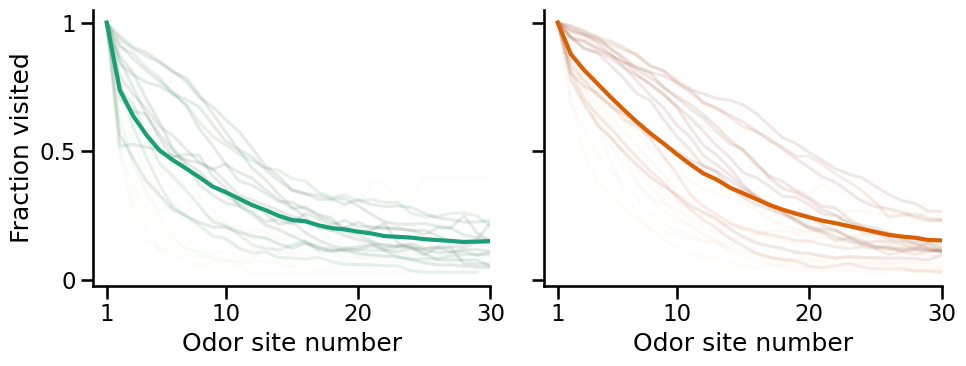

In [41]:
# Filter the summary_df to only keep patches they visit
summary_df = summary_df.loc[((summary_df.site_number == 0) & (summary_df.is_choice == 1)) | (summary_df.site_number != 0)]
summary_df = summary_df.loc[summary_df.engaged == 1]

# Group by mouse, experiment, and patch_label to calculate the number of unique patches visited
patch_df = summary_df.groupby(['mouse', 'experiment','session',  'patch_label']).agg({'patch_number': 'nunique'}).reset_index()

# Merge the patch_df back with summary_df to calculate the number of patches attempted
final_df = pd.merge(summary_df, patch_df, on=['mouse', 'session', 'experiment', 'patch_label'], how='left', suffixes=('', '_attempted'))

# Group by mouse, site_number, experiment, and patch_label to calculate the number of patches visited and attempted
final_df = final_df.groupby(['mouse', variable,  'session', 'experiment', 'patch_label']).agg({'patch_number': 'nunique', 'patch_number_attempted': 'mean', }).reset_index()

# Calculate the fraction of patches visited
final_df['fraction_visited'] = final_df['patch_number'] / final_df['patch_number_attempted']

dictionary = {'0': color3, '60': color2, '90': color1}
palette = {
    '0': 'Purples',  # Amyl Acetate
    '60': 'Greens',  # Alpha-pinene
    '90': 'Oranges',  # Ethyl Butyrate
}
new_df = final_df.groupby(['mouse','experiment', 'session', variable, 'patch_label']).fraction_visited.mean().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for ax, patch_label in zip(axes.flatten(), new_df.patch_label.unique()):
    sns.lineplot(data=new_df.loc[(new_df.patch_label == patch_label)&(new_df.experiment == "control")&(new_df.site_number >0)], x=variable, y='fraction_visited', hue = 'mouse', ci=None, ax=ax, alpha = 0.1, legend=False, palette = palette[patch_label])
    
    sns.lineplot(data=new_df.loc[(new_df.patch_label == patch_label)&(new_df.experiment == "control")&(new_df.site_number >0)], x=variable, y='fraction_visited', ci=None, ax=ax, legend=False, color = dictionary[patch_label], linewidth=3)

    ax.set_xlim(0, max_value)
    ax.set_xlabel('Odor site number')
    ax.set_ylabel('Fraction visited')
    ax.set_xticks(ticks=[1,10,20,30], labels=['1', '10', '20', '30'], rotation=0, ha='center')
    ax.set_yticks(ticks=[0,0.5,1], labels=['0', '0.5', '1'])
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'fraction_visited_vs_{variable}_hue_patch_label.svg'))

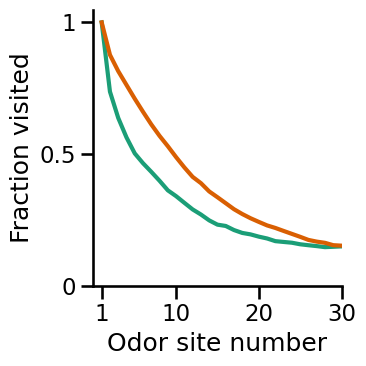

In [80]:
new_df = final_df.groupby(['mouse','experiment', 'session', variable, 'patch_label']).fraction_visited.mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
sns.lineplot(data=new_df.loc[(new_df.experiment == "control")&(new_df.site_number >0)], x=variable, y='fraction_visited', ci=None, ax=ax, hue='patch_label', legend=False, palette= dictionary, linewidth=3)
ax.set_xlim(0, max_value)
ax.set_xlabel('Odor site number')
ax.set_ylabel('Fraction visited')
plt.xticks(ticks=[1,10,20,30], labels=['1', '10', '20', '30'], rotation=0, ha='center')
plt.yticks(ticks=[0,0.5,1], labels=['0', '0.5', '1'])
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(results_path, f'fraction_visited_vs_{variable}.pdf'))

### Raster

In [4]:
from aind_vr_foraging_analysis.utils.parsing import data_access

date_string = "2025-8-5" # YYYY-MM-DD
mouse = '798279' # mouse ID

# This section will look at all the session paths that fulfill the condition
session_paths = data_access.find_sessions_relative_to_date(
    mouse=mouse,
    date_string=date_string,
    when='on'
)

# Iterate over the session paths and load the data
for session_path in session_paths:
    print(f"Loading {session_path.name}...")
    try:
        all_epochs, stream_data, data = data_access.load_session(
            session_path
        )
        odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']
    
    except Exception as e:
        print(f"Error loading {session_path.name}: {e}")
    

Loading 798279_2025-08-05T155621Z...
Reward functions from software events


In [8]:
def trial_collection(
    reward_sites: pd.DataFrame,
    continuous_data: pd.DataFrame,
    aligned: str = 'index',
    cropped_to_length: str = 'window',
    window: list = [-0.5, 2],
    taken_col: str = "filtered_velocity",
    continuous: bool = True,
):
    """
    Crop the snippets of speed traces that are aligned to different epochs

    Parameters
    ----------
    reward_sites : pd.DataFrame
        DataFrame containing the reward sites information (odor sites)
    continuous_data : pd.DataFrame
        DataFrame containing the continuous data (encoder, sniffing, etc)
    mouse : str
        Mouse name
    session : str
        Session name
    aligned : str
        Column name to align the snippets
    window : tuple
        Time window to crop the snippets
    taken_col: string
        name of the column that you want to segment the data from. Default is 'filtered_velocity'

    Returns
    -------
    trial_summary : pd.DataFrame
        DataFrame containing the snippets of speed traces aligned to different epochs

    """
    trial_summary = pd.DataFrame()
    samples_per_second = np.around(np.mean(continuous_data.index.diff().dropna()), 3)
    
    # Iterate through reward sites and align the continuous data to whatever value was chosen. If aligned is used, it will align to any of the columns with time values.
    # If align is empty, it will align to the index, which in the case of the standard reward sites is the start of the odor site.
    for start_reward, row in reward_sites.iloc[:-1].iterrows():
        if cropped_to_length == 'sniff':
            # window[0] = -1
            # window[1] = row['odor_duration']
            window[0] = 0
            window[1] = row['next_index'] - start_reward   
        elif cropped_to_length == 'patch':    
            window[0] = row['time_since_entry']
            window[1] = row['exit_epoch']
        elif cropped_to_length == 'epoch':
            window[0] = 0
            window[1] = row['duration_epoch']
        elif cropped_to_length == 'choose':
            window[0] = row[window[0]]
            window[1] = row[window[1]]
        else:
            pass
            
        trial_average = pd.DataFrame()
        if aligned != 'index':
            trial = continuous_data[(continuous_data.index >= row[aligned] + window[0]) & (continuous_data.index < row[aligned] + window[1])][taken_col]
            trial.index -= row[aligned]
            time_reference = row[aligned]
        else:
            trial = continuous_data.loc[
                start_reward + window[0] : start_reward + window[1], taken_col
            ]

            trial.index -= start_reward
            time_reference = start_reward
        
        if continuous == True:
            # Assuming trial.values, window, and samples_per_second are defined
            # Calculate the maximum number of intervals that can fit within the available data points
            max_intervals = len(trial.values) * samples_per_second

            # Calculate the actual stop value based on the maximum possible intervals
            actual_stop = min(window[1], window[0] + max_intervals)

            # Generate the time range with the adjusted stop value
            times = np.arange(window[0], actual_stop, samples_per_second)
            if len(times) != len(trial.values):
                # print('Different timing than values, ', len(times), len(trial.values))
                trial = trial.values[:len(times)]
            else:
                trial = trial.values
            trial_average["times"] = times

        else:
            trial_average["times"] = trial.index     
            trial = trial.values    
             
        
        trial_average['time_reference'] = time_reference
        
        if len(trial) == len(trial_average["times"]):
            if "filtered_velocity" == taken_col:
                trial_average["speed"] = trial
            else:
                trial_average[taken_col] = trial
        else:
            continue
            
        # Rewrites all the columns in the reward_sites to be able to segment the chosen traces in different values
        for column in reward_sites.columns:
            trial_average[column] = np.repeat(row[column], len(trial))
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

    return trial_summary


In [10]:
def raster_with_velocity(
    active_site: pd.DataFrame,
    stream_data: pd.DataFrame,
    save = False,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
    with_velocity: bool = True,
    barplots: bool = True,
):
    

    # sort by odor label, then by original site for stability
    df_sorted = active_site.sort_values(["patch_label", "patch_number"]).reset_index(drop=True)

    # re-enumerate "site" but keep repetitions grouped
    df_sorted["patch_number"] = df_sorted.groupby(["patch_label", "patch_number"]).ngroup() + 1
    active_site = df_sorted.copy()
    
    test_df = active_site.groupby('patch_number').agg({'time_since_entry': 'min', 'patch_onset': 'mean','exit_epoch' : 'max'})
    test_df.reset_index(inplace=True)
    test_df.fillna(15, inplace=True)   
    
    trial_summary = trial_collection(test_df, stream_data.encoder_data, aligned='patch_onset', cropped_to_length='patch')
    n_patches = active_site.patch_number.nunique()
    n_max_stops = active_site.site_number.max() + 1
    fig, ax1 = plt.subplots(figsize=(15+ n_max_stops/2, n_patches/2))
    ax2 = ax1.twinx()
    
    max_speed = np.quantile(trial_summary['speed'],0.99)
    for index, row in active_site.iterrows():
        if row['label'] == 'InterPatch':
            color = '#b3b3b3'
        elif row['label'] == 'InterSite':
            color = '#808080'
        elif row['label'] == 'PostPatch':
            color = '#b3b3b3'
            
        if row['label'] == 'OdorSite':
            if row['site_number'] == 0:
                ax1.scatter(-20, row.patch_number, color=color_dict_label[row.patch_label], marker='s', s=60, edgecolor='black', linewidth=0.0)

            if row["is_reward"] == 1 and row["is_choice"] == True:
                color = "steelblue"
            elif row["is_reward"] == 0 and row["is_choice"] == True:
                color = "pink"
            else:
                color = 'yellow'
                
        if barplots:
            ax1.barh(int(row['patch_number']), left=row.time_since_entry, height=0.85, width=row.duration_epoch, color=color,  linewidth=0.5)
        
        if with_velocity:
            if row['time_since_entry'] <0:
                current_trial = trial_summary[trial_summary['patch_number'] == row['patch_number']]

                ax2.plot(current_trial['times'], (current_trial['speed']+10)*0.75+(max_speed*(row['patch_number']))+max_speed/1.8, color='black', linewidth=1.5, alpha=0.8)
                ax2.set_ylim(0, max_speed*(active_site['patch_number'].max()+2))

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Patch number")
    sns.despine()
    ax1.set_ylim(-1, max(active_site.patch_number) + 1)
    
    if active_site.groupby('patch_number').time_since_entry.min().min() < -50:
        time_left = -50
    else:
        time_left = active_site.groupby('patch_number').time_since_entry.min().min()
    
    if active_site.groupby('patch_number').time_since_entry.max().max() > 300:
        time_right = 250
    else:
        time_right = active_site.groupby('patch_number').time_since_entry.max().max()
      
    ax1.set_xlim(time_left, time_right)
    
    # Create legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()
        return fig

In [6]:
color1 = '#d95f02'
color2 = '#1b9e77'
color3 = '#7570b3'

color_dict_label = {'InterSite': '#808080',
'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02',
'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
'PatchB': '#d95f02','PatchA': '#1b9e77',
'PatchC': '#7570b3',
'Alpha-pinene': '#1b9e77', 
'Methyl Butyrate': '#7570b3', 
'Amyl Acetate': '#d95f02', 
'Fenchone': '#7570b3', 
'Dipropyl sulfide': '#7570b3',
'Dypropil sulfide': '#7570b3',
'Hexanal': '#1b9e77',
'Pentyl acetate': '#d95f02',
'S': color1,
'D': color2,
'N': color3,   
'Do': color1,
'odor_0': color3,
'odor_60': color2,
'odor_90': color1,
'A': color1,
'B': color2,
'C': color3,
}

In [7]:
all_epochs.patch_label.unique()

array(['PatchA', 'PatchC', 'PatchB'], dtype=object)

In [13]:
all_epochs = all_epochs.loc[all_epochs.patch_number < 100]

In [11]:
import matplotlib.backends.backend_pdf as pdf
with pdf.PdfPages(os.path.join(results_path, f'{mouse}_raster.pdf')) as save:
    raster_with_velocity(all_epochs, stream_data, color_dict_label=color_dict_label,  with_velocity=False, save=save)

In [12]:
import matplotlib.backends.backend_pdf as pdf
with pdf.PdfPages(os.path.join(results_path, f'{mouse}_raster_velocity.pdf')) as save:
    raster_with_velocity(all_epochs, stream_data, color_dict_label=color_dict_label,  with_velocity=True, save=save)

In [19]:
import os

folder = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\manuscript\results\figures"
mice = ["mouse1", "mouse2", "mouse3"]  # replace with your mouse names
file_patterns = [
    "velocity_last_visit_stop_{}.pdf",
    "velocity_length_bin_{}.pdf",
    "velocity_last_visit_choice{}.pdf"
]


mice = ['754570','754579','754567','754580','754559','754560','754577','754566','754570','754571','754574','754575', '754582','745302','745305','745301', '789911', '789913', '789919', '789918', '789908', '788641']
with open("index.html", "w") as f:
    f.write("<html><body><h1>VR Foraging PDFs</h1><ul>\n")
    for mouse in mice:
        for pattern in file_patterns:
            filename = pattern.format(mouse)
            full_path = os.path.join(folder, filename).replace("\\", "/")
            url = "file:///" + full_path.replace(" ", "%20")
            f.write(f'<li><a href="{url}" target="_blank">{filename}</a></li>\n')
    f.write("</ul></body></html>")
